In [3]:
import typing as tp
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
from collections import defaultdict

In [21]:
def rsign():
    return 1 if np.random.random() < 0.5 else -1

In [22]:
#prices
prices = {}

In [392]:
class RandomFeed:
    def __init__(self,
                 vol,
                 px: float,
                 #mid,
                 window: int,
                 dist_args=None,
                 distribution=np.random.normal,
                 **kwargs):
        '''Args:
            vol: volatility
            px: beginning px for history
            mid: the market id
            window: the length of the windowSize for TWAP
            dist_args: args that go into the distribution;
                for a gaussian, the center and the std
            
        '''

        self.distribution = distribution
        self.vol = vol
        self.px = px
        #self.id = mid
        self.window = window
        self.dist_args = (0,1)
        self.block_times = [0]
        self.cumul_px = [px]
        self.prices = [px]
        self.twaps = []
        self.returns = []
        self.kwargs = kwargs

    @staticmethod
    def block_time():
        # time it took to mine ith block in seconds
        return 13.23 + rsign()*np.random.rand()
    
    def get_returns(self, arr:np.array):
        # to get returns of any series
        arr_init = np.roll(arr, 1)
        returns = (arr/arr_init) - 1
        return returns[1:] #delete spurious return
    
    def get_twap(self, i:int, window=-1):
        if window < 0:
            window = self.window
        #ith block , window is number of blocks we average over
        if i < self.window:
            return
        else:
            return (self.cumul_px[i] - self.cumul_px[i - window])/window
    
    def update(self, modify_vol=False, **kwargs):      
        #WARNING!  an in-place method that mutates the class                                             
                                                     
        delta = self.get_delta(**kwargs)
        self.px += (self.vol * delta) 
        
        if self.px <= 0:
             raise Exception('the market price went to zero')
               
        block_time = t()
        
        #here we populate all the dynamic lists and 
        self.prices.append(self.px)
        self.cumul_px.append(self.cumul_px[-1] + block_time*self.px)
        self.block_times.append(block_time)
        self.returns.append(self.prices[-1]/self.prices[-2] - 1)
        
        if modify_vol:
            self.vol = kwargs['vol']

    def get_delta(self, **kwargs):
        #if the % moves are small relative to self.px, then the trader results will be unrealistic. 
        #px needs to move as a % of the price level to reflect compounding
        if kwargs.get('pct', False):
            standard_dev = self.vol*self.px/100   
            center = standard_dev/10  #self.dist_args[0]
            args = (center, standard_dev)
            delta = self.distribution(*args)  # if self.dist_args else self.distribution()    
        else:
            delta = self.distribution(*self.dist_args) if self.dist_args else self.distribution()
        delta = self.distribution(*self.dist_args) if self.dist_args else self.distribution()
        return delta  
    


In [393]:
np.random.seed(1)
markets = {
    0:RandomFeed(vol=1, px = 1e3, window=50, dist_args=(0, 1)),
    #1:RandomFeed(vol=1, px = 1e3, window=150, dist_args=(0, 1)),
    #2:RandomFeed(vol=1, px = 1e3, window=300, dist_args=(0, 1)),
    #3:RandomFeed(vol=1, px = 1e3, window=150, dist_args=(0, 1)),
    }
m = markets[0]
for _ in range(10000):
    m.update()

In [394]:
### test your get_returns method
rets = m.get_returns(m.prices)
all(map(np.isclose, m.returns, rets))

True

In [395]:
twaps = np.array([m.get_twap(i) for i in range(50,10000)])

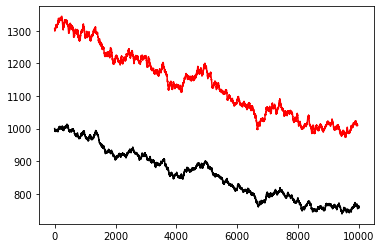

In [396]:
plt.plot(m.prices, c='k')
plt.plot(twaps/10, c='r')

# The TWAP and the spot price are very different numbers , what about the returns?

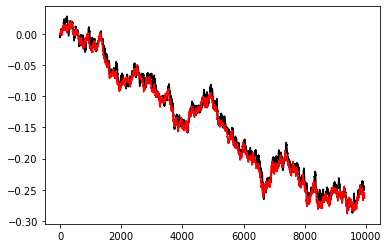

In [397]:
twap_crets = np.cumsum(m.get_returns(twaps))
crets = np.cumsum(m.returns[m.window:])

plt.plot(twap_crets, c='k')
plt.plot(crets, c='r')

# Zoom in

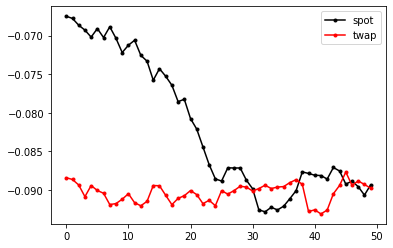

In [398]:
plt.plot(twap_crets[3000:3050], marker='.', c='k', label='spot')
plt.plot(crets[3000:3050], marker='.', c='r', label='twap')
plt.legend()

# Because of the averaging, there are arbitrage opportunities between spot and TWAP prices. How extreme are these opportunities? 

In [399]:
#on a block-by-block basis
twap_rets = m.get_returns(twaps)
ret_diff = m.returns[51:] - twap_rets
print(f'max + return difference: +{max(ret_diff)},\nmax - return difference: {min(ret_diff)}')
print('\n')
#buy and hold, waiting for divergence to get out
cret_diff = crets[1:] - twap_crets
print(f'max + cumulative return difference: +{max(cret_diff)},\nmax - cumulative return difference: {min(cret_diff)}')

max + return difference: +0.006291579746074194,
max - return difference: -0.00592785402338647


max + cumulative return difference: +0.02102752765466276,
max - cumulative return difference: -0.03517420471279564


# How does the TWAP change as we change the `windowSize`?

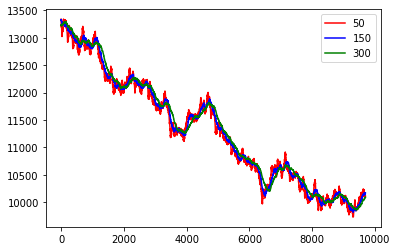

In [402]:
twaps = {}
for i in [50,150,300]: #different window sizes, 300 is approx 1 hr
    twaps[i] = np.array([m.get_twap(j, window=i) for j in range(i,10000)])
#plt.plot(m.prices[300:], c='k')
plt.plot(twaps[50][250:], c='r', label='50')
plt.plot(twaps[150][150:], c='b',label='150')
plt.plot(twaps[300], c='g',label='300')
plt.legend()

In [404]:
#they have different lengths,  be careful
list(map(len, twaps.values()))

[9950, 9850, 9700]

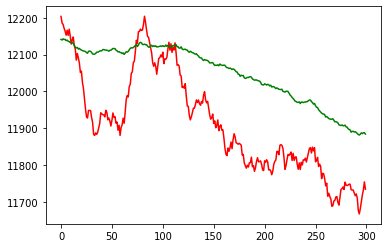

In [409]:
plt.plot(twaps[50][3000:3300], c='r', label='50')
plt.plot(twaps[300][2750:3050], c='g',label='300') #need to offset by 250 to align

In [410]:
twap_crets = np.cumsum(m.get_returns(twaps[300]))
crets = np.cumsum(m.returns[301:])

assert len(twap_crets) == len(crets)

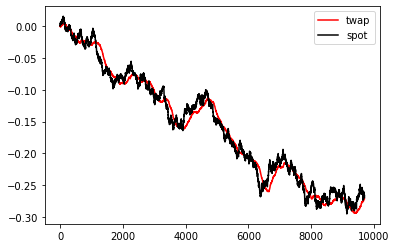

In [411]:
plt.plot(twap_crets, c='r', label='twap')
plt.plot(crets, c='k', label='spot')
plt.legend()

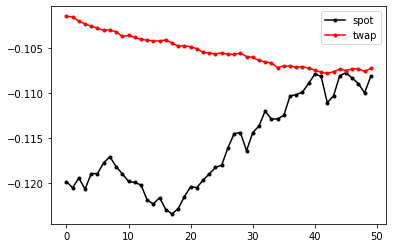

In [412]:
plt.plot(crets[3000:3050], marker='.', c='k', label='spot')
plt.plot(twap_crets[3000:3050], marker='.', c='r', label='twap')
plt.legend()

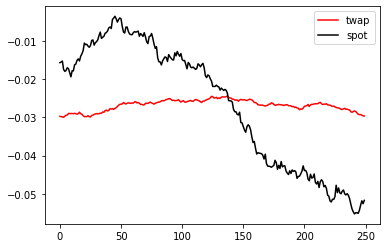

In [413]:
plt.plot(twap_crets[1000:1250], c='r', label='twap')
plt.plot(crets[1000:1250], c='k', label='spot')
plt.legend()

In [415]:
#on a block-by-block basis
twap_rets = m.get_returns(twaps[300])
ret_diff = m.returns[301:] - twap_rets
print(f'max + return difference: +{max(ret_diff)},\nmax - return difference: {min(ret_diff)}')
print('\n')
#buy and hold, waiting for divergence to get out
cret_diff = crets - twap_crets
print(f'max + cumulative return difference: +{max(cret_diff)},\nmax - cumulative return difference: {min(cret_diff)}')

max + return difference: +0.004872836628034949,
max - return difference: -0.004636973513953535


max + cumulative return difference: +0.0453587122216943,
max - cumulative return difference: -0.038057960141136826


# The main concern is that the TWAP can be predicted. Let's see if this is the case

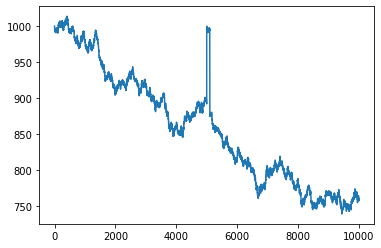

In [416]:
prices_w_shock = m.prices.copy()
shock_block = 5000
for i in range(100):
    prices_w_shock[shock_block + i] = prices_w_shock[i]  
plt.plot(prices_w_shock)

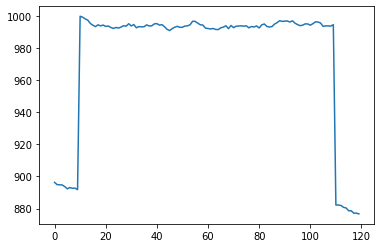

In [430]:
plt.plot(prices_w_shock[shock_block-10:shock_block+110])

In [418]:
import copy
Shock = copy.deepcopy(m)
window = 300
Shock.prices = prices_w_shock
Shock.returns = Shock.get_returns(np.array(prices_w_shock))
Shock.cumul_px = np.cumsum(list(map(np.multiply, Shock.block_times, Shock.prices)))
Shock_twaps = np.array([Shock.get_twap(j, window=window) for j in range(window,10000)])

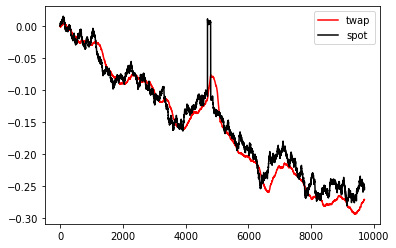

In [419]:
twap_crets = np.cumsum(Shock.get_returns(Shock_twaps))
crets = np.cumsum(Shock.returns[window:])

plt.plot(twap_crets, c='r', label='twap')
plt.plot(crets, c='k', label='spot')
plt.legend()

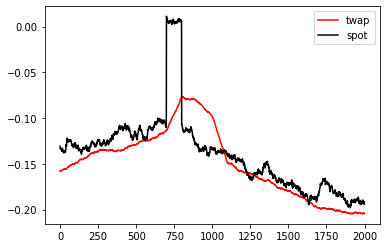

In [422]:
plt.plot(twap_crets[4000:6000], c='r', label='twap')
plt.plot(crets[4000:6000], c='k', label='spot')
plt.legend()

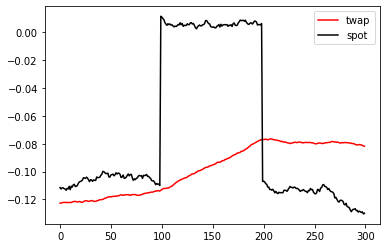

In [425]:
shock_time = shock_block-window

plt.plot(twap_crets[shock_time-100:shock_time+100+100], c='r', label='twap')
plt.plot(crets[shock_time-100:shock_time+100+100], c='k', label='spot')
plt.legend()

In [429]:
(twap_crets[shock_time+100] -twap_crets[shock_time]) 

0.035857625595267506

# A 10% shock occuring in 10 blocks (a couple minutes) and lasting for 100 blocks (20 minutes) leads to about 3.5% of free profit for anyone paying attention. What is worse is that, because of the time delay, the price does not immediately revert when the spot price has an opposite shock. 

In [4]:
FILENAME = "mc-1627502207.7848918-filtered"

# OK, let's look at monte carlo sims. Data generated for 3 months every block assuming 15s blocks. Fit used to generate sample points assumes Levy process, with log stable increments

# Fit based on ETH/USDC 120d worth of data w 10min candles. Sim points generated every 15s

In [5]:
df = pd.read_csv(f"csv/{FILENAME}.csv")
df

,Unnamed: 0,sim-0,sim-1,sim-3,sim-5,sim-17,sim-22,sim-36,sim-38,sim-39,...,sim-72,sim-76,sim-77,sim-83,sim-89,sim-91,sim-93,sim-94,sim-97,sim-98
0,0,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,...,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000
1,1,2257.279939,2239.635583,2239.409648,2239.094328,2239.760435,2239.796242,2239.750602,2240.430580,2239.417710,...,2239.938046,2239.420321,2239.679258,2239.517582,2239.318892,2239.339680,2239.529045,2239.679989,2239.809589,2239.484089
2,2,2256.965792,2239.605222,2239.267675,2239.050133,2239.888765,2239.791825,2239.242870,2240.002148,2239.213937,...,2240.022457,2239.233272,2239.691800,2239.240016,2239.302512,2239.621831,2239.378811,2239.273305,2238.563352,2239.233271
3,3,2256.706637,2239.333992,2239.432515,2237.433049,2238.922973,2240.031993,2239.386863,2239.706611,2239.122091,...,2240.235425,2239.673608,2238.520212,2239.447428,2239.764958,2239.793826,2239.381085,2238.744148,2238.784563,2238.896240
4,4,2257.705008,2240.500107,2239.547802,2237.308286,2239.140346,2239.931609,2240.015802,2239.730837,2238.947734,...,2239.934672,2240.046417,2238.285628,2239.886464,2239.934240,2239.995334,2238.865671,2238.706849,2238.663632,2240.015180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518396,518396,4174.489419,906.705980,6157.105814,367.560558,195.905552,3314.593940,403.041701,8906.875086,3085.968418,...,1690.435861,19.376452,2584.766372,2181.585887,962.129536,3032.097362,1067.191654,9180.367870,2834.303017,3741.589612
518397,518397,4173.715783,906.519268,6157.561302,367.610972,195.885391,3313.934908,402.951137,8906.405720,3086.108355,...,1687.754736,19.378207,2584.720787,2181.946576,962.098430,3031.955090,1066.845260,9180.012436,2833.928540,3740.045180
518398,518398,4174.649734,906.736253,6158.126843,367.681718,195.913516,3314.246217,402.456515,8907.964768,3085.927212,...,1687.885219,19.379282,2583.785731,2183.254626,962.206680,3031.872773,1067.057273,9180.881484,2833.470085,3740.032175
518399,518399,4174.341345,906.878986,6158.762760,367.669851,196.010765,3313.808611,402.236807,8907.538585,3085.025612,...,1687.746931,19.377603,2583.822224,2183.000443,962.354298,3032.868904,1067.320077,9180.609562,2833.829332,3740.222330


# Start out with something relatively tame like sim 53. Calculate the TWAP over averaging times of 30m, 1h, 8h

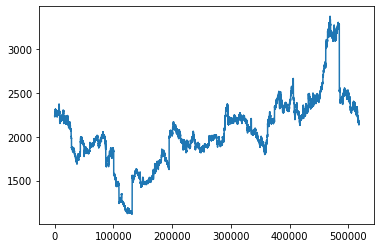

In [6]:
sim_filter = [0, 1, 3, 5, 17, 22, 36, 38, 39, 42, 43, 47, 49, 53, 55, 56, 63, 64, 65, 69, 71, 72, 76, 77, 83, 89, 91, 93, 94, 97, 98]
df['sim-53'].plot()

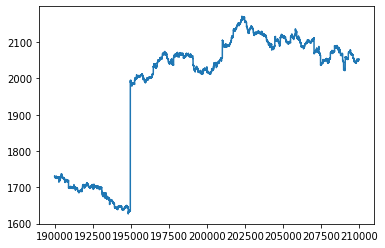

In [7]:
df['sim-53'][190000:210000].plot()

In [8]:
print(df.columns)
df = df.rename(columns={'Unnamed: 0': 'block'})
df

Index(['Unnamed: 0', 'sim-0', 'sim-1', 'sim-3', 'sim-5', 'sim-17', 'sim-22',
       'sim-36', 'sim-38', 'sim-39', 'sim-42', 'sim-43', 'sim-47', 'sim-49',
       'sim-53', 'sim-55', 'sim-56', 'sim-63', 'sim-64', 'sim-65', 'sim-69',
       'sim-71', 'sim-72', 'sim-76', 'sim-77', 'sim-83', 'sim-89', 'sim-91',
       'sim-93', 'sim-94', 'sim-97', 'sim-98'],
      dtype='object')


,block,sim-0,sim-1,sim-3,sim-5,sim-17,sim-22,sim-36,sim-38,sim-39,...,sim-72,sim-76,sim-77,sim-83,sim-89,sim-91,sim-93,sim-94,sim-97,sim-98
0,0,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,...,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000,2239.570000
1,1,2257.279939,2239.635583,2239.409648,2239.094328,2239.760435,2239.796242,2239.750602,2240.430580,2239.417710,...,2239.938046,2239.420321,2239.679258,2239.517582,2239.318892,2239.339680,2239.529045,2239.679989,2239.809589,2239.484089
2,2,2256.965792,2239.605222,2239.267675,2239.050133,2239.888765,2239.791825,2239.242870,2240.002148,2239.213937,...,2240.022457,2239.233272,2239.691800,2239.240016,2239.302512,2239.621831,2239.378811,2239.273305,2238.563352,2239.233271
3,3,2256.706637,2239.333992,2239.432515,2237.433049,2238.922973,2240.031993,2239.386863,2239.706611,2239.122091,...,2240.235425,2239.673608,2238.520212,2239.447428,2239.764958,2239.793826,2239.381085,2238.744148,2238.784563,2238.896240
4,4,2257.705008,2240.500107,2239.547802,2237.308286,2239.140346,2239.931609,2240.015802,2239.730837,2238.947734,...,2239.934672,2240.046417,2238.285628,2239.886464,2239.934240,2239.995334,2238.865671,2238.706849,2238.663632,2240.015180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518396,518396,4174.489419,906.705980,6157.105814,367.560558,195.905552,3314.593940,403.041701,8906.875086,3085.968418,...,1690.435861,19.376452,2584.766372,2181.585887,962.129536,3032.097362,1067.191654,9180.367870,2834.303017,3741.589612
518397,518397,4173.715783,906.519268,6157.561302,367.610972,195.885391,3313.934908,402.951137,8906.405720,3086.108355,...,1687.754736,19.378207,2584.720787,2181.946576,962.098430,3031.955090,1066.845260,9180.012436,2833.928540,3740.045180
518398,518398,4174.649734,906.736253,6158.126843,367.681718,195.913516,3314.246217,402.456515,8907.964768,3085.927212,...,1687.885219,19.379282,2583.785731,2183.254626,962.206680,3031.872773,1067.057273,9180.881484,2833.470085,3740.032175
518399,518399,4174.341345,906.878986,6158.762760,367.669851,196.010765,3313.808611,402.236807,8907.538585,3085.025612,...,1687.746931,19.377603,2583.822224,2183.000443,962.354298,3032.868904,1067.320077,9180.609562,2833.829332,3740.222330


In [9]:
prices = df['sim-53']
prices

0         2239.570000
1         2239.667466
2         2240.655710
3         2238.304510
4         2239.584944
             ...     
518396    2179.164884
518397    2180.037396
518398    2179.911487
518399    2179.797703
518400    2180.034550
Name: sim-53, Length: 518401, dtype: float64

In [10]:
# This is number of blocks into the future
blocks = df['block']
blocks

0              0
1              1
2              2
3              3
4              4
           ...  
518396    518396
518397    518397
518398    518398
518399    518399
518400    518400
Name: block, Length: 518401, dtype: int64

In [13]:
# 1h price changes
# Use the geometric mean to be consistent with uni v3: https://uniswap.org/whitepaper-v3.pdf
# Compare with arithmetic mean as well ...
window_1h = 4*60

dp_1h_arith = prices.rolling(window=window_1h).sum()
dt_1h = blocks.rolling(window=window_1h).apply(lambda w: w[-1]-w[0]+1, raw=True)
dt_1h

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
518396    240.0
518397    240.0
518398    240.0
518399    240.0
518400    240.0
Name: block, Length: 518401, dtype: float64

In [14]:
twap_1h_arith = (dp_1h_arith / dt_1h)
twap_1h_arith = twap_1h_arith[~twap_1h_arith.isnull()]
twap_1h_arith

239       2238.890016
240       2238.884368
241       2238.879010
242       2238.868694
243       2238.867567
             ...     
518396    2161.297954
518397    2161.377192
518398    2161.456294
518399    2161.531477
518400    2161.606372
Length: 518162, dtype: float64

In [15]:
# Geometric mean is a bit more annoying given inf in pd. Do it all through rolling apply knowing dt is always 240 blocks in this sim
twap_1h_geo = prices.rolling(window=window_1h).apply(lambda w: w[0] * (np.prod(w/w[0]))**(1/window_1h), raw=True)
twap_1h_geo = twap_1h_geo[~twap_1h_geo.isnull()]
twap_1h_geo

239       2238.888859
240       2238.883210
241       2238.877853
242       2238.867539
243       2238.866412
             ...     
518396    2161.265451
518397    2161.344353
518398    2161.423125
518399    2161.497987
518400    2161.572553
Name: sim-53, Length: 518162, dtype: float64

In [16]:
prices_filtered = prices[239:]
prices_filtered

239       2237.622746
240       2238.214274
241       2238.381596
242       2238.179852
243       2238.034022
             ...     
518396    2179.164884
518397    2180.037396
518398    2179.911487
518399    2179.797703
518400    2180.034550
Name: sim-53, Length: 518162, dtype: float64

# Compare what TWAP arithmetic, geometric vs spot look like near a spot jump

In [17]:
prices_filtered[194710:194760]

194949    1637.445701
194950    1637.247430
194951    1637.421921
194952    1636.634825
194953    1636.663335
194954    1636.650276
194955    1636.749059
194956    1635.894670
194957    1635.856624
194958    1635.430328
194959    1635.315208
194960    1634.585924
194961    1633.767173
194962    1633.765022
194963    1633.796563
194964    1634.757899
194965    1634.983232
194966    1635.193521
194967    1634.694454
194968    1634.704682
194969    1634.698519
194970    1634.724512
194971    1994.326618
194972    1990.126144
194973    1989.787615
194974    1989.552402
194975    1988.576333
194976    1988.713652
194977    1988.674788
194978    1988.696268
194979    1988.999884
194980    1989.234997
194981    1989.008158
194982    1989.095215
194983    1989.152632
194984    1989.476140
194985    1989.942940
194986    1989.624463
194987    1990.070219
194988    1989.968677
194989    1989.188977
194990    1989.960421
194991    1989.434537
194992    1989.031456
194993    1989.041240
194994    

# Notice, there's a 360 USD (22%) jump over 1 block, which is unrealistic (larger tails in log stable than in reality). Should likely use 10min data to get more realistic sense, but this is good to stress test. Will come back to using 10min data later in notebook.

In [18]:
twap_1h_arith[194710:194760]

194949    1639.848098
194950    1639.799708
194951    1639.749869
194952    1639.698266
194953    1639.645923
194954    1639.596900
194955    1639.547413
194956    1639.493362
194957    1639.437896
194958    1639.380414
194959    1639.322263
194960    1639.266878
194961    1639.208955
194962    1639.145160
194963    1639.081097
194964    1639.019885
194965    1638.955612
194966    1638.893635
194967    1638.829073
194968    1638.765166
194969    1638.699826
194970    1638.635522
194971    1640.072081
194972    1641.493586
194973    1642.917156
194974    1644.339188
194975    1645.756711
194976    1647.174849
194977    1648.592427
194978    1650.007003
194979    1651.423193
194980    1652.839931
194981    1654.260080
194982    1655.681324
194983    1657.106640
194984    1658.533988
194985    1659.963602
194986    1661.390022
194987    1662.819405
194988    1664.247851
194989    1665.675496
194990    1667.107350
194991    1668.536743
194992    1669.964004
194993    1671.391759
194994    

In [24]:
print(twap_1h_geo[194710:194760])
print(twap_1h_geo[194710:195000])

194949    1639.835271
194950    1639.786976
194951    1639.737247
194952    1639.685742
194953    1639.633503
194954    1639.584567
194955    1639.535174
194956    1639.481218
194957    1639.425854
194958    1639.368475
194959    1639.310428
194960    1639.255109
194961    1639.197238
194962    1639.133530
194963    1639.069560
194964    1639.008461
194965    1638.944333
194966    1638.882496
194967    1638.818074
194968    1638.754307
194969    1638.689118
194970    1638.624962
194971    1639.921370
194972    1641.206823
194973    1642.495581
194974    1643.783985
194975    1645.069594
194976    1646.356726
194977    1647.644333
194978    1648.929929
194979    1650.217927
194980    1651.507312
194981    1652.801287
194982    1654.097312
194983    1655.398404
194984    1656.702329
194985    1658.009225
194986    1659.314165
194987    1660.622797
194988    1661.931589
194989    1663.241168
194990    1664.555474
194991    1665.868711
194992    1667.181119
194993    1668.495054
194994    

# Timelag in the TWAP vs spot is clear. Now let's plot and add in bid/ask spread.

## Bid/ask spread based off last point added to accumluator + 99% confidence constant E_B. Limits probability of profitable trade 1h into future once TWAP catches up to spot

## dB = P_{t-1} * e^{ (1/T) * [X_t + E_B ] } - TWAP_{t}

## where T is averaging window for the TWAP.

## Q: Do we want to min the exponent so it's never less than TWAP_{t} for B nor greater than TWAP_{t} for ask?

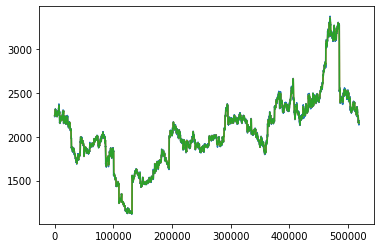

In [19]:
ax = prices_filtered.plot()
twap_1h_geo.plot(ax=ax)
twap_1h_arith.plot(ax=ax)

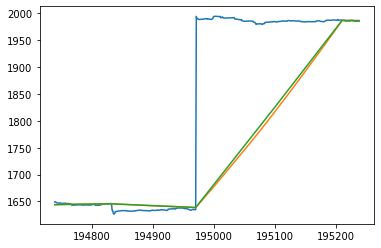

In [20]:
ax = prices_filtered[194500:195000].plot()
twap_1h_geo[194500:195000].plot(ax=ax)
twap_1h_arith[194500:195000].plot(ax=ax)

# Playing catch up over 240 blocks after spot jump with TWAP

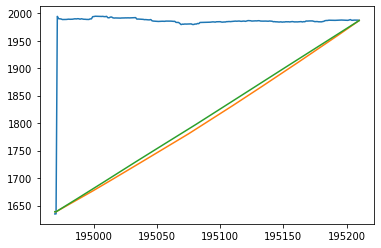

In [21]:
ax = prices_filtered[194730:194972].plot()
twap_1h_geo[194730:194972].plot(ax=ax)
twap_1h_arith[194730:194972].plot(ax=ax)

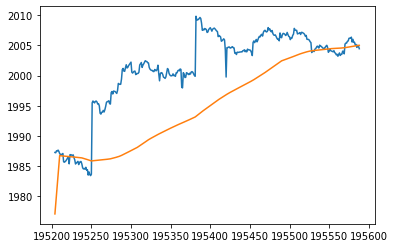

In [22]:
ax = prices_filtered[194965:195350].plot()
twap_1h_geo[194965:195350].plot(ax=ax)

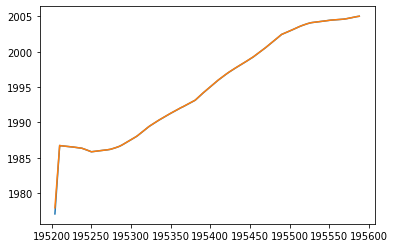

In [23]:
ax = twap_1h_geo[194965:195350].plot()
twap_1h_arith[194965:195350].plot(ax=ax)

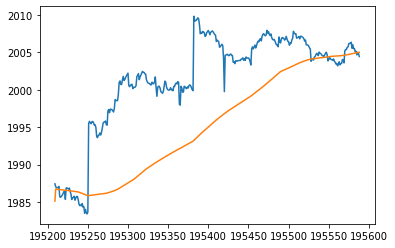

In [24]:
# Focus on only 240 block timespan to check catch up
ax = prices_filtered[194970:195350].plot()
twap_1h_geo[194970:195350].plot(ax=ax)

In [25]:
print(prices_filtered[194970:195025])
print(twap_1h_geo[194970:195025])

195209    1987.427329
195210    1987.061184
195211    1986.902750
195212    1986.925091
195213    1986.913355
195214    1987.084465
195215    1985.698910
195216    1985.637224
195217    1985.750202
195218    1985.887878
195219    1986.114328
195220    1986.326442
195221    1986.469949
195222    1985.365886
195223    1986.880659
195224    1986.879325
195225    1986.832025
195226    1986.723653
195227    1986.858808
195228    1986.403009
195229    1986.030006
195230    1985.337765
195231    1985.569617
195232    1985.600455
195233    1985.773879
195234    1985.244777
195235    1985.563615
195236    1985.743142
195237    1985.738180
195238    1985.327255
195239    1984.702402
195240    1984.520949
195241    1984.596926
195242    1984.485857
195243    1984.791574
195244    1984.313530
195245    1984.401755
195246    1983.497403
195247    1984.019650
195248    1983.589147
195249    1983.410406
195250    1983.653382
195251    1995.482323
195252    1995.783461
195253    1995.607815
195254    

In [26]:
# Jump in spot occurs from 195250 to 195251
print(np.log(1995.482323/1983.653382))
np.exp(0.005945500089474321/240)*np.exp(np.log(1.007))

# geometric TWAP value at 19250 is 1985.848948; 19251 is 1985.863894
1985.863894*np.exp(0.005945500089474321/240)*np.exp(np.log(1.007))

# Perfect. It's above the jump

0.005945500089474321


1999.8144818826183

In [27]:
# We could make it way more intense by instead using the current spot price as the top of the buy band ...
print(1995.482323*np.exp(0.005945500089474321/240)*np.exp(np.log(1.007)))

# Yea then it's way higher.

2009.50047983307


In [138]:
# Check that we catch up at 195251+240 = 195491
print(prices_filtered[194970:195025])
print(twap_1h_geo[195210:195265])

195209    1987.427329
195210    1987.061184
195211    1986.902750
195212    1986.925091
195213    1986.913355
195214    1987.084465
195215    1985.698910
195216    1985.637224
195217    1985.750202
195218    1985.887878
195219    1986.114328
195220    1986.326442
195221    1986.469949
195222    1985.365886
195223    1986.880659
195224    1986.879325
195225    1986.832025
195226    1986.723653
195227    1986.858808
195228    1986.403009
195229    1986.030006
195230    1985.337765
195231    1985.569617
195232    1985.600455
195233    1985.773879
195234    1985.244777
195235    1985.563615
195236    1985.743142
195237    1985.738180
195238    1985.327255
195239    1984.702402
195240    1984.520949
195241    1984.596926
195242    1984.485857
195243    1984.791574
195244    1984.313530
195245    1984.401755
195246    1983.497403
195247    1984.019650
195248    1983.589147
195249    1983.410406
195250    1983.653382
195251    1995.482323
195252    1995.783461
195253    1995.607815
195254    

In [28]:
# 195491    2002.483630
# Geometric twap is at 2002.483630 after an hour. Bid up with 0.7% envelope had it at 1999.8144818826183.
# So trader can profit ... 0.1334% => which is 0 after fees [x]
(2002.483630-1999.8144818826183)/1999.8144818826183

0.001334697864008307

# Ok! Bid/ask envelope seems potentially promising. Let's see it live in action. Add in envelope values to 1h TWAP for bid/ask. Don't have it adjust only on side with jump (try this later)

In [30]:
# Spread that makes unwinding over the next hour during TWAP catchup unprofitable ~99% of time
# SPREAD_X is e^X exponent component
SPREAD_X = np.log(1.00731)
SPREAD_X

0.007283411446258746

In [33]:
print('Long side price adjust up (Ask):', np.exp(SPREAD_X))
print('Short side price adjust down (Bid):', np.exp(-SPREAD_X))

Long side price adjust up: 1.00731
Short side price adjust down: 0.9927430483168043


In [36]:
twap_1h_geo_ask = twap_1h_geo.apply(lambda x: x * np.exp(SPREAD_X))
twap_1h_geo_bid = twap_1h_geo.apply(lambda x: x * np.exp(-SPREAD_X))

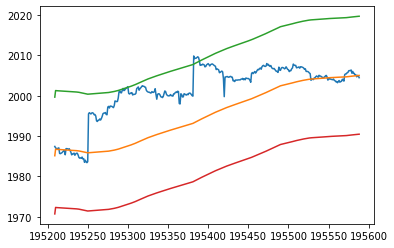

In [37]:
ax = prices_filtered[194970:195350].plot()
twap_1h_geo[194970:195350].plot(ax=ax)
twap_1h_geo_ask[194970:195350].plot(ax=ax)
twap_1h_geo_bid[194970:195350].plot(ax=ax)

In [55]:
print("prices_filtered", prices_filtered[195012:195013])
print("twap_1h_geo", twap_1h_geo[195012:195013])
print("twap_1h_geo_ask", twap_1h_geo_ask[195012:195013])
print("twap_1h_geo_bid", twap_1h_geo_bid[195012:195013])

prices_filtered 195251    1995.482323
Name: sim-53, dtype: float64
twap_1h_geo 195251    1985.863894
Name: sim-53, dtype: float64
twap_1h_geo_ask 195251    2000.380559
Name: sim-53, dtype: float64
twap_1h_geo_bid 195251    1971.452575
Name: sim-53, dtype: float64


In [56]:
1985.863894 * np.exp(SPREAD_X)

2000.38055906514

In [57]:
np.exp(SPREAD_X)

1.00731

In [58]:
0.00731 * 1985.863894

14.51666506514